In [1]:
#import necessary libraries
from igraph import *
import networkx as nx
from tqdm import tqdm
from joblib import Parallel, delayed
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
# g = Graph(directed=True)
# g
#directed graph
g = nx.DiGraph()

In [3]:
print(g)

DiGraph with 0 nodes and 0 edges


In [4]:
def humanize_unixtime(unix_time):
    time = datetime.fromtimestamp(int(unix_time)).strftime('%d-%m-%Y %H.%M.%S')
    return time

In [5]:
def get_details(input_type, month):
    
    #hashes list to store all the hashes
    details_dict = dict()
    
    #read files
    if input_type == "inputs":
        filename = "./Data/edges2010/updated/inputs2010_{}.txt".format(str(month+2))
    if input_type == "outputs":
        filename = "./Data/edges2010/updated/outputs2010_{}.txt".format(str(month+2))

    with open(filename) as file:
        for line in file:
            #split by tab char to get the details present
            line = line.replace('\n', '')
            details = line.split("\t")

            #hash present at the second value
            #append in the list
            details_dict[details[1]] = dict()
            
            if input_type == "inputs":
                details_dict[details[1]]['time'] = details[0]
                details_dict[details[1]]["input"] = details[2:]
                details_dict[details[1]]["human"] = humanize_unixtime(details[0])
                
            if input_type == "outputs":
                details_dict[details[1]]["output"] = details[2:]
                details_dict[details[1]]["time"] = details[0]
                details_dict[details[1]]["human"] = humanize_unixtime(details[0])
            
    return details_dict

In [6]:
#as there is data file for each month
month = 1

#input dict to store all the input details
input_dict = dict()

#output dict to store all the output details
output_dict = dict()

In [7]:
import time
start_time = time.time()

#calling function
inp = Parallel(n_jobs=-1)(delayed(get_details)("inputs", i) for i in tqdm(range(month)))
for d in inp:
    input_dict.update(d)

end_time = time.time()
print("Time taken to read the input file data is {}".format(end_time - start_time))

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 146.20it/s]


Time taken to read the input file data is 0.5070240497589111


In [8]:
print("Total details in input dict is: {}".format(len(input_dict)))

Total details in input dict is: 142


In [9]:
import time
start_time = time.time()

#calling function
inp = Parallel(n_jobs=-1)(delayed(get_details)("outputs", i) for i in tqdm(range(month)))
for d in inp:
    output_dict.update(d)

end_time = time.time()
print("Time taken to read the output file data is {}".format(end_time - start_time))

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 252.23it/s]

Time taken to read the output file data is 0.07257676124572754


In [10]:
print("Total details in output dict is: {}".format(len(output_dict)))

Total details in output dict is: 142


In [11]:
#merge input and output data
for key, value in output_dict.items():
    input_details = input_dict[key]
    output_dict[key]["input"] = input_details["input"]

print("Total details in linked dict is: {}".format(len(output_dict)))

Total details in linked dict is: 142


In [12]:
output_dict

{'2613': {'output': ['19uf6F6EDijkH4ZUaqsi3pZ2SVD6A5RG8X', '5000000000'],
  'time': '1265417221',
  'human': '05-02-2010 18.47.01',
  'input': ['6a43325dc0a1dfd17020788262550e7d222f7cf601663f88ea186ac61efa64e2',
   '0']},
 '40338': {'output': ['noaddress',
   '2500000000',
   '1PyNKEyqtDFB4HBG8ueDVxdPZfgwC6gAqw',
   '2500000000'],
  'time': '1265951870',
  'human': '11-02-2010 23.17.50',
  'input': ['5ef95e74138b73ba65ce47985ec81db57d5198d8a9c2cf23ccccacb42609c295',
   '0']},
 '28526': {'output': ['19k8nToWwMGuF4HkNpzgoVAYk4viBnEs5D', '105000000000'],
  'time': '1265139093',
  'human': '02-02-2010 13.31.33',
  'input': ['f9f9264b30b87fadd2846cccedb510c96c3e89ead2b2844cf09cd0ad6f6fa5b1',
   '0',
   'f8538ba662c2bb7c0a55087aed1b1bc05815147989ce52a53d31f0fb1ac971ab',
   '0',
   '13a9f37dba76f6a5def094d32749fe4eaa5a4f075e36cdf66f5d48f67feaebbb',
   '0',
   '294501b3f2c65fdcd95bb5cac6dab571278e55ef806ba061c93264eba61fa402',
   '0',
   '8ca075f2a1b068f3529a0d921aee23ebac989242c0e2e54b84d8176

In [13]:
updated_dict = dict(sorted(output_dict.items(), key=lambda item: item[1]['time']))

In [14]:
for key, value in tqdm(updated_dict.items()):
    
    #print("Current transaction hash {}".format(key))
    hash_of_transc = key
    
    
    input_details_of_hash_of_transc = value["input"]
    output_details_of_hash_of_transc = value["output"]
    
    #print("Transaction input details {}".format(input_details_of_hash_of_transc))
    #print("Transaction output details {}".format(output_details_of_hash_of_transc))
    
    #going over all input transactions
    for i in range(0, len(input_details_of_hash_of_transc), 2):
        
        input_hash = input_details_of_hash_of_transc[i]
        output_index = input_details_of_hash_of_transc[i+1]
        
        #print(input_hash)
        #print(output_index)
        if input_hash not in updated_dict.keys():
            #g.add_vertex(input_hash)
            #print("no address")
            pass
        else:
            #g.add_vertex(input_hash)
            #get output details of that input transaction
            get_amounts = updated_dict[input_hash]["output"]
            
            #print(get_amounts)
            address = get_amounts[int(output_index)]
            amount = get_amounts[2*int(output_index)+1]
            
            
            #add input transaction node
            g.add_node(input_hash, s='s', label='transaction', color="r")
            
            #add address node
            g.add_node(address, s ='s', label='address', color="b")
            
            #add output transaction node
            g.add_node(hash_of_transc, s='o', label='transaction', color="r")
            
            #add edge between input transaction and address
            g.add_edge(input_hash, address, weight=int(amount))
            
            #add edge between address and output transaction
            g.add_edge(address, key, weight=int(amount))

        
            #g.add_edge(input_hash, key, weight=amount)
            #g.add_edge(input_hash, key)
            #g.es["weights"] = amount
        

100%|██████████████████████████████████████| 142/142 [00:00<00:00, 16662.22it/s]


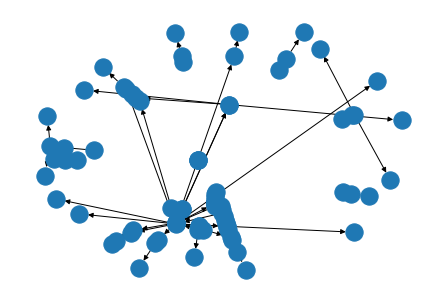

In [15]:
import matplotlib.pyplot as plt
nx.draw(g)

In [16]:
# pos = nx.nx_agraph.graphviz_layout(g)
# #nx.draw(g, pos=pos)
# write_dot(g, 'file.dot')

In [17]:
from stellargraph import StellarGraph
square_foo_bar = StellarGraph.from_networkx(g)
print(square_foo_bar.info())

2021-11-16 20:30:14.510203: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-16 20:30:14.510301: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


StellarDiGraph: Directed multigraph
 Nodes: 96, Edges: 101

 Node types:
  transaction: [70]
    Features: none
    Edge types: transaction-default->address
  address: [26]
    Features: none
    Edge types: address-default->transaction

 Edge types:
    transaction-default->address: [58]
        Weights: range=[1e+06, 1.9e+12], mean=1.69528e+11, std=3.88977e+11
        Features: none
    address-default->transaction: [43]
        Weights: range=[1e+06, 1.9e+12], mean=2.11205e+11, std=4.37716e+11
        Features: none


2021-11-16 20:30:22.928660: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-16 20:30:22.929260: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-16 20:30:22.929299: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-16 20:30:22.929357: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bumblebee): /proc/driver/nvidia/version does not exist
2021-11-16 20:30:22.930137: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appro

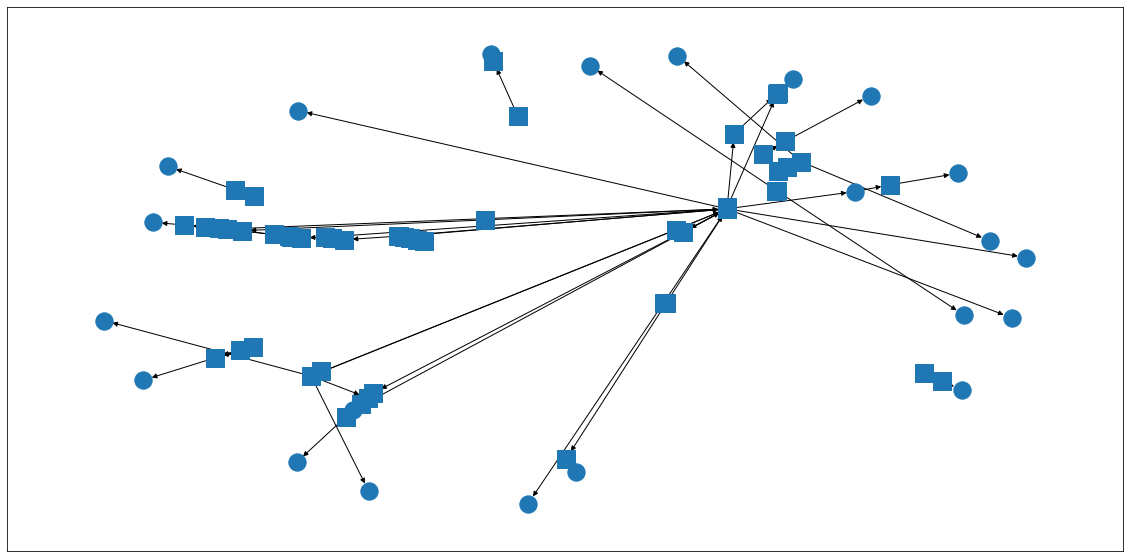

In [18]:
plt.figure(figsize=(20, 10))
nodePos = nx.layout.spring_layout(g)
nodeShapes = set((aShape[1]["s"] for aShape in g.nodes(data = True)))
for aShape in nodeShapes:
    #...filter and draw the subset of nodes with the same symbol in the positions that are now known through the use of the layout.
    nx.draw_networkx_nodes(g,nodePos, node_shape = aShape, nodelist = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,g.nodes(data = True))])

#Finally, draw the edges between the nodes
nx.draw_networkx_edges(g,nodePos)
plt.show()